In [1]:
import os, glob, shutil
import cv2
import numpy as np
import urllib.request as r
import torch, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch import nn


In [2]:
#CONSONANT VARIABLES
SAVE_DIR, SAVE_PREFIX = "data/model_files", "arthropodia" #for model saving 
SIZE = 320
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

# 1-Data preparation

In [3]:

# a)datasetni yuklab olish
def download_dataset(path_to_download, dataset_name = "arthropodia"): 
    
    dataset_names = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "apple_disease", "arthropodia"]
    
    assert dataset_name in dataset_names, f"Mavjud bo'lgan dataset {dataset_names} dan birini kiriting!"
    if dataset_name == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    if dataset_name == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif dataset_name == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif dataset_name == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif dataset_name == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif dataset_name == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif dataset_name == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif dataset_name == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif dataset_name == "arthropodia": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    
    # Check if is already exist 
    if os.path.isfile(f"{path_to_download}/{dataset_name}.csv") or os.path.isdir(f"{path_to_download}/{dataset_name}"): 
        print(f"Dataset allaqachon yuklab olingan. {path_to_download}/{dataset_name} papkasini ni tekshiring."); 

    # If data doesn't exist in particular folder
    else: 
        ds_name = url.split("/")[-1] 
        # Download the dataset
        print(f"{ds_name} yuklanmoqda...")
        os.system(f"{url} -p {path_to_download}")
        shutil.unpack_archive(f"{path_to_download}/{ds_name}.zip", extract_dir=f"{path_to_download}/{dataset_name}")
        os.remove(f"{path_to_download}/{ds_name}.zip")
        print(f"Tanlangan dataset {path_to_download}/{dataset_name} papkasiga yuklab olindi!")
    
    return f"{path_to_download}/{dataset_name}"
    
dataset_path = download_dataset(path_to_download = "data", dataset_name = "arthropodia")
print(dataset_path)


Dataset allaqachon yuklab olingan. data/arthropodia papkasini ni tekshiring.
data/arthropodia


In [4]:
#Transformations from albumentations
import albumentations as A 
train_tfs = A.Compose([A.Resize(SIZE, SIZE), A.VerticalFlip(0.5), A.HorizontalFlip(0.5), A.GaussNoise(0.2)])
test_tfs = A.Compose([A.Resize(SIZE, SIZE)])
print("Train:",train_tfs,"\n Test:", test_tfs)

Train: Compose([
  Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
  VerticalFlip(always_apply=0.5, p=0.5),
  HorizontalFlip(always_apply=0.5, p=0.5),
  GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.2), per_channel=True, mean=0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True) 
 Test: Compose([
  Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [5]:
# l) Dataset binary yoki multiclass dataset ekanligini aniqlang;
# m) Har bir datasetdagi datani olib kelish uchun CustomDataset class ni yozing: har bir 
# datadan 2ta o’zgaruvchi qaytishi kerak, birinchisi input rasm (tensor), ikkinchisi output rasm (tensor);

#make a Custom dataset class 
class ArthropodiaDataset(Dataset): 
    def __init__(self, dataset_path, transformations = None):
        super().__init__()
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.image_paths = sorted(glob.glob(f"{dataset_path}/*/images/*"))
        self.label_paths = sorted(glob.glob(f"{dataset_path}/*/labels/*"))

        # print(self.image_paths)
        # print(self.label_paths)
    
    def __len__(self):  return len(self.image_paths)

    def __getitem__(self, index): 

        image = cv2.cvtColor(cv2.imread(self.image_paths[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.label_paths[index]), cv2.COLOR_BGR2GRAY)

        if self.transformations is not None: 
            transformed = self.transformations(image = image, mask = mask)
            image = transformed['image']
            mask = transformed['mask'] 

        image = self.tensorize(image)
        mask = torch.tensor(mask>128).long()
        
        return image, mask 
    
arthropodia_ds = ArthropodiaDataset(dataset_path=dataset_path, transformations=train_tfs)
print(len(arthropodia_ds))
print(torch.unique(arthropodia_ds[0][1]))
print(arthropodia_ds[0][0].shape)
print(arthropodia_ds[0][1].shape)

4949
tensor([0, 1])
torch.Size([3, 320, 320])
torch.Size([320, 320])


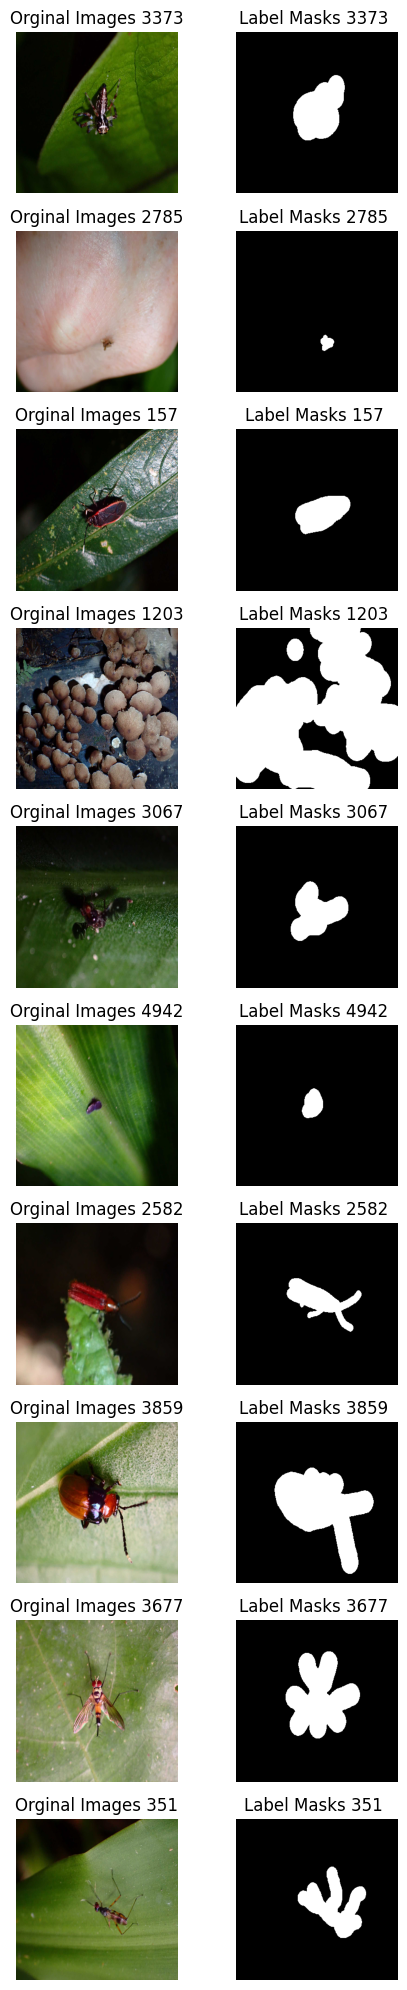

In [6]:
#n) Dataset binary yoki multiclass dataset ekanligini aniqlang;
# o) Datasetdagi datani olib kelish uchun CustomDataset class ni yozing: har bir datadan 2ta o’zgaruvchi qaytishi kerak, 
#  birinchisi input rasm (tensor), ikkinchisi output rasm (tensor);
# p) Datasetdagi rasm va mos javob (mask) larni chizib ko’rsatadigan visualization kodni yozing: 
# plt.imshow yordamida rasmni chizib, plt.title yordamida rasmning Input Rasm yoki GT Mask eknaligini yozib, ko’rsating:

##See examples from data 
def get_random_data(num_images): 
  """This function gets converted from tensor to numpy images in quantity of num_images argument  
     and return original image list, label mask images list and random numbers according to num_images"""
  
  data = []
  for i in range(num_images):
      random_index = np.random.randint(1, len(arthropodia_ds))
      tensor_img, tensor_label = arthropodia_ds[random_index] #get random index image and label from dataset
      np_image = ((tensor_img)*255).cpu().permute(1,2,0).numpy().astype("uint8") #tensor to np
      np_label = tensor_label.cpu().numpy().astype('uint8')
      data.append((np_image, np_label, random_index))

  return data

plot_data = get_random_data(10)
# Create figure and subplots (side-by-side in this example)
fig, axes = plt.subplots(len(plot_data), 2, figsize=(5, len(plot_data)*2))  # Adjust figsize as needed 
# Loop through image and labels and plot
for i in range(len(plot_data)):
  axes[i, 0].imshow(plot_data[i][0])
  axes[i, 1].imshow(plot_data[i][1], cmap='gray')
  axes[i, 0].set_title(f"Orginal Images {plot_data[i][2]}")
  axes[i, 1].set_title(f"Label Masks {plot_data[i][2]} ")
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [7]:
# q) Datasetni train, validation, va test setlariga ajratib, train, validation, va test dataloaderlarni yarating;
from torch.utils.data import random_split

train_data, valid_data, test_data  = random_split(dataset = arthropodia_ds, 
                                               lengths = [0.9, 0.05, 0.05],
                                               generator = torch.Generator().manual_seed(13)) 

print(f"Train data size:{len(train_data)}   |  Valid data size:{len(valid_data)}    |    Test data size: {len(test_data)}")

bs = 10
train_dataloader = DataLoader(dataset = train_data, batch_size=bs, shuffle=True,num_workers=0)
val_dataloader = DataLoader(dataset = valid_data, batch_size=bs, shuffle=False,num_workers=0 )
test_dataloader = DataLoader(dataset = test_data, batch_size=bs,  shuffle=False, num_workers=0)

print(f"Train dataloader size:{len(train_dataloader)}   |  Valid dataloader size:{len(val_dataloader)}    |    Test dataloader size: {len(test_dataloader)}\n")

print("One data point example size")
dataiter = iter(train_dataloader)

images, masks = next(dataiter)
print(images.shape)
print(masks.shape)
 

Train data size:4455   |  Valid data size:247    |    Test data size: 247
Train dataloader size:446   |  Valid dataloader size:25    |    Test dataloader size: 25

One data point example size
torch.Size([10, 3, 320, 320])
torch.Size([10, 320, 320])


# 2 SEGMENTATION MODEL

## 2.1 U-net from scratch

In [8]:
# import torch.nn.functional as F
# from typing import List 

# class UNetBlock(nn.Module):
    

#     def __init__(self, in_chs: int, out_chs: int, ks: int = 3, p: int = 1):
#         super().__init__()
        
#         # Get kernel size and padding value
#         self.ks, self.p = ks, p
        
#         # Initialize the first and the second convolution blocks
#         self.block_1 = self.get_conv_block(in_chs = in_chs, out_chs = out_chs)
#         self.block_2 = self.get_conv_block(in_chs = out_chs, out_chs = out_chs)

#     def get_conv_block(self, in_chs: int, out_chs: int):
               
#         return nn.Sequential(
#                nn.Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = self.ks, padding = self.p),
#                nn.BatchNorm2d(out_chs), 
#                nn.ReLU(inplace = True)
#                             )
    
#     def forward(self, inp): return self.block_2(self.block_1(inp))

# class DownSampling(nn.Module):
    
#     def __init__(self, in_chs, out_chs):
#         super().__init__()
        
#         self.downsample_block = nn.Sequential(  nn.MaxPool2d(2), UNetBlock(in_chs, out_chs) )

#     def forward(self, x): return self.downsample_block(x)


# class UpSampling(nn.Module):

#     def __init__(self, in_chs, out_chs, mode, upsample=None):
#         super().__init__()
        
#         if mode in ['bilinear', 'nearest']: 
#             upsample = True
#             up_mode = mode
#         self.upsample = nn.Upsample(scale_factor=2, mode=up_mode) if upsample else nn.ConvTranspose2d(in_chs, in_chs // 2, kernel_size=2, stride=2)
#         self.conv = UNetBlock(in_chs, out_chs)

#     def forward(self, inp1, inp2):
        
#         inp1 = self.upsample(inp1)
        

#         pad_y = inp2.shape[2] - inp1.shape[2]
#         pad_x = inp2.shape[3] - inp1.shape[3]
#         # print(inp1.shape)
#         # print(inp2.shape)
#         inp1 = F.pad(inp1, [pad_x // 2, pad_x - pad_x // 2, pad_y // 2, pad_y - pad_y // 2])
        
#         assert inp1.shape == inp2.shape, "Concatetation bajarish uchun tensor larning hajmi bir xil bo'lishi kerak!"
#         #print(inp1.shape)
#         return self.conv(torch.cat([inp2, inp1], dim=1))

# class FinalConv(nn.Module):
#     def __init__(self, in_chs, out_chs):
#         super().__init__()
        
#         self.conv = nn.Conv2d(in_chs, out_chs, kernel_size = 1)

#     def forward(self, inp): return self.conv(inp)
    
# class UNet(nn.Module):
    
#     def __init__(self, in_chs, n_cls, out_chs, up_method):
#         super().__init__()
        
#         assert up_method in ['bilinear', 'nearest', 'tr_conv'], "Please choose a proper method for upsampling"
#         self.init_block = UNetBlock(in_chs, out_chs)
#         factor = 2 if up_method in ['bilinear', 'nearest'] else 1 
#         self.in_chs, self.n_cls = in_chs, n_cls
#         self.init_block = UNetBlock(in_chs, out_chs)
        
#         self.enc_block_1 = DownSampling(out_chs, out_chs * 2)
#         self.enc_block_2 = DownSampling(out_chs * 2, out_chs * 4)
#         self.enc_block_3 = DownSampling(out_chs * 4, out_chs * 8)
#         self.enc_block_4 = DownSampling(out_chs * 8, out_chs * 16 // factor)
        
        
#         self.dec_block_1 = UpSampling(out_chs * 16, out_chs * 8 // factor, up_method) 
#         self.dec_block_2 = UpSampling(out_chs * 8, out_chs * 4 // factor, up_method) 
#         self.dec_block_3 = UpSampling(out_chs * 4, out_chs * 2 // factor, up_method)
#         self.dec_block_4 = UpSampling(out_chs * 2, (out_chs // factor) * 2 if up_method in ['bilinear', 'nearest'] else (out_chs // factor), up_method)
#         self.final_conv = FinalConv(out_chs, n_cls)
        
#     def forward(self, inp):
        
#         init_conv = self.init_block(inp)
        
#         enc_1 = self.enc_block_1(init_conv)
#         enc_2 = self.enc_block_2(enc_1)
#         enc_3 = self.enc_block_3(enc_2)
#         enc_4 = self.enc_block_4(enc_3)
        
#         dec_1 = self.dec_block_1(enc_4, enc_3)
#         dec_2 = self.dec_block_2(dec_1, enc_2)
#         dec_3 = self.dec_block_3(dec_2, enc_1)
#         dec_4 = self.dec_block_4(dec_3, init_conv)
        
#         return self.final_conv(dec_4)

# model = UNet(in_chs = 3, n_cls = 2, out_chs = 64, up_method = 'tr_conv')
# a = torch.rand(1,3,240, 240)
# print(model(a).shape)

## 2.2 pretrained segmentation_models_pytorch

In [12]:
#r) Train jarayoni uchun AI model ni yarating. segmentation_models_pytorch library dagi biror bir model yoki o’zingiz 
# CustomModel ni tanlashingiz mumkin.num_classes ni o’zgartirishni unutmang;
import segmentation_models_pytorch as smp
# model = smp.Unet(encoder_name = "efficientnet-b0", in_channels=3, classes = 2, encoder_depth = 5, encoder_weights = "imagenet", activation = None, decoder_channels = [256, 128, 64, 32, 16])
model = smp.DeepLabV3(encoder_name="resnet34", encoder_depth=5, encoder_weights="imagenet", decoder_channels=256, in_channels=3, classes = 2,activation = None, upsampling=8,aux_params=None)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\murod/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.8MB/s]


DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

# 3-Build a model

#### Metrics and  IOU

In [13]:
# s) Train jarayoni ni hisoblash uchun evaluation metrics (loss, pixel accuracy, intersection over union) larni yarating;
class Metrics():
    def __init__ (self, pred , gt, loss_fn , n_cls = 2):
 
        self.pred=torch.argmax(torch.nn.functional.softmax (pred, dim = 1), dim = 1 )
        self.gt = gt 
        self.loss_fn = loss_fn 
        self.n_cls = n_cls 
        self.pred_ = pred 
        
    def loss(self) :   return  self.loss_fn(self.pred_, self.gt)       
    
    def to_contiguous (self,inp) : 
        """ Runtime: input is not contigious erroridan qochish uchun. Yani ayrim view, transpose kabi  funksiyalarni ishlatganda
         xotira adressini ozgartiradi. contiguous ni ishlatsak xotirani ozgartirmasdan yangi tensor kopiya qiladi  """
        return inp.contiguous().view(-1)
    
    def PA (self):
        """Pixel accuracy. Pixel accuracy = (To'gri topilgan pixellar sonini) / (Rasmdagi barcha pixellar soniga)"""
        with torch.no_grad():
            match = torch.eq(self.pred , self.gt).int()  #pred va gt ni bir biriga togrilarini topish
        return float(match.sum()) / float(match.numel()) 
    
    def mIoU (self):
        """mean Intersection over Union"""
        
        with torch.no_grad():
            pred , gt = self.to_contiguous (self.pred), self.to_contiguous(self.gt)
            iou_per_class = []
            
            for c in range (self.n_cls):
                #prediction va gt ni n_clas dagilarga mosligini tekshirib koradi 
                #masalan: n_cls 2 bolsa yani 0 va 1. har birini 0 yoki 1 ga tengligini tekshirib chiqadi
                match_pred = pred == c 
                match_gt = gt == c 
                
                #gt larni mos kelish yigindisi 0 ga teng bolib qolsa, yanikim 2 ta pixel valueadan boshqa paydo bolib qolsa
                #boshqa rang yoki boshqa narsa
                if match_gt.long().sum().item() == 0 : iou_per_class.append(np.nan) #np.nan - not a number nan qiymat qaytaradi
                else : 
                        
                    #logical_and - kesishgan qismini olish. Ikkovida ham mavjud qism
                    #logical_or - ikkovida ham mavjud bolsa bolmasa olinadigon qism
                    intersection = torch.logical_and (match_pred , match_gt).sum().float().item() 
                    union = torch.logical_or (match_pred , match_gt).sum().float().item()
                    
                    iou = (intersection ) / (union)
                    iou_per_class.append(iou) #har bir class uchun alohida yoziladi. 1-0 klass uchun 2-loopda 1 klass uchun
                    
            return np.nanmean(iou_per_class)

### Training 

In [15]:
def train(model, tr_dl, val_dl, loss_fn, optim, epochs, n_cls):
    
    tr_loss_list, tr_pa_list, tr_iou_list = [],[],[] 
    val_loss_list, val_pa_list, val_iou_list = [],[],[] 
    tr_len, val_len = len(tr_dl), len(val_dl)
    
    best_loss = 0
    os.makedirs(f"{SAVE_DIR}", exist_ok=True)
    for epoch in range(epochs): 
        print("-------------------------------------------------")
        print(f"{epoch+1} - EPOCH PROCESS STARTED....".upper())   
        model.train()

        tr_epoch_loss, tr_epoch_pa, tr_epoch_iou = 0, 0, 0   
        print(f"TRAINING...".upper())  
        for (images, masks) in tqdm.tqdm(tr_dl): 
             
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            predictions = model(images)
            
            #get metrics in each batch per loop
            met = Metrics(pred=predictions, gt=masks, loss_fn=loss_fn, n_cls=n_cls)
            losses = met.loss()
            #har bir batchlarni metricslarini qoshib ketad. 10 ta batch bolsa 10 tasini summasini chiqarida
            tr_epoch_loss += losses.item()
            tr_epoch_pa += met.PA()
            tr_epoch_iou += met.mIoU() 

            optimizer.zero_grad()
            losses.backward()
            optim.step()


        """VALDIATION """
        print(f"VALIDATIONING...".upper())
        model.eval()
        val_epoch_loss, val_epoch_pa, val_epoch_iou = 0, 0, 0
        with torch.no_grad():       
            for (images, masks) in tqdm.tqdm(val_dl): 
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                predictions = model(images)
                
                #get metrics in each batch 
                met = Metrics(pred=predictions, gt=masks, loss_fn=loss_fn)
                losses = met.loss()

                #har bir val batchlarni metricslarni qoshib ketadi
                val_epoch_loss += losses.item()
                val_epoch_pa += met.PA()
                val_epoch_iou += met.mIoU() 
        

        #Har bir epoch uchun loss, pixel acc, va iou ni topib olamiz. 
        #Buning uchun tr loss, pa, mio ni jami data soniga bo'lamiz. 
        tr_epoch_loss /= tr_len
        tr_epoch_pa /= tr_len
        tr_epoch_iou /= tr_len

        val_epoch_loss /= val_len
        val_epoch_pa /= val_len
        val_epoch_iou /= val_len
        
        #Har bir epochdagi train, val loss va accuracy natijalarni listga store qilib ketamiz. 
        tr_loss_list.append(tr_epoch_loss) 
        tr_pa_list.append(tr_epoch_pa)
        tr_iou_list.append(tr_epoch_iou)

        val_loss_list.append(val_epoch_loss) 
        val_pa_list.append(val_epoch_pa)
        val_iou_list.append(val_epoch_iou)

            
        print("-------------------------------------------------")
        print(f"TRAINING RESULTS:")
        print(f"Train loss : {tr_epoch_loss:.3f}")
        print(f"Train PA   : {tr_epoch_pa:.3f}")
        print(f"Train mIoU : {tr_epoch_iou:.3f}\n")

        print(f"VALDIATION RESULTS:")
        print(f"Validation loss : {val_epoch_loss:.3f}")
        print(f"Validation PA   : {val_epoch_pa:.3f}")
        print(f"Validation mIoU : {val_epoch_iou:.3f}")

        print(f"{epoch+1} - EPOCH PROCESS FINISHED....".upper())   
        print("-------------------------------------------------")

        if val_epoch_loss > best_loss: 
            best_loss = val_epoch_loss 
            torch.save(model, f=f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth")
        
    return {"tr_loss": tr_loss_list, "tr_pa": tr_pa_list, "tr_iou": tr_iou_list,
            "val_loss": val_loss_list, "val_pa": val_pa_list, "val_iou": val_iou_list}


#run the training and validationing
model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)
result_dict = train(model = model,tr_dl = train_dataloader, val_dl=val_dataloader,  loss_fn = loss_fn, optim=optimizer, epochs=15, n_cls=2)



-------------------------------------------------
1 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:49<00:00,  1.54it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.069
Train PA   : 0.971
Train mIoU : 0.861

VALDIATION RESULTS:
Validation loss : 0.078
Validation PA   : 0.969
Validation mIoU : 0.848
1 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
2 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:08<00:00,  1.79it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.068
Train PA   : 0.972
Train mIoU : 0.863

VALDIATION RESULTS:
Validation loss : 0.086
Validation PA   : 0.964
Validation mIoU : 0.835
2 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
3 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:29<00:00,  1.65it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.055
Train PA   : 0.977
Train mIoU : 0.884

VALDIATION RESULTS:
Validation loss : 0.078
Validation PA   : 0.969
Validation mIoU : 0.851
3 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
4 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:27<00:00,  1.67it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.051
Train PA   : 0.978
Train mIoU : 0.891

VALDIATION RESULTS:
Validation loss : 0.075
Validation PA   : 0.972
Validation mIoU : 0.859
4 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
5 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:14<00:00,  1.75it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.052
Train PA   : 0.978
Train mIoU : 0.892

VALDIATION RESULTS:
Validation loss : 0.079
Validation PA   : 0.969
Validation mIoU : 0.850
5 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
6 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:23<00:00,  1.69it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.047
Train PA   : 0.980
Train mIoU : 0.900

VALDIATION RESULTS:
Validation loss : 0.074
Validation PA   : 0.973
Validation mIoU : 0.863
6 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
7 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:23<00:00,  1.69it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.043
Train PA   : 0.981
Train mIoU : 0.907

VALDIATION RESULTS:
Validation loss : 0.073
Validation PA   : 0.973
Validation mIoU : 0.863
7 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
8 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:21<00:00,  1.70it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.042
Train PA   : 0.982
Train mIoU : 0.910

VALDIATION RESULTS:
Validation loss : 0.077
Validation PA   : 0.972
Validation mIoU : 0.858
8 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
9 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:17<00:00,  1.73it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.078
Train PA   : 0.968
Train mIoU : 0.848

VALDIATION RESULTS:
Validation loss : 0.078
Validation PA   : 0.968
Validation mIoU : 0.849
9 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
10 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:25<00:00,  1.68it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.75it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.048
Train PA   : 0.980
Train mIoU : 0.899

VALDIATION RESULTS:
Validation loss : 0.073
Validation PA   : 0.973
Validation mIoU : 0.862
10 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
11 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:29<00:00,  1.66it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.042
Train PA   : 0.982
Train mIoU : 0.911

VALDIATION RESULTS:
Validation loss : 0.080
Validation PA   : 0.970
Validation mIoU : 0.851
11 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
12 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:26<00:00,  1.67it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.037
Train PA   : 0.984
Train mIoU : 0.921

VALDIATION RESULTS:
Validation loss : 0.081
Validation PA   : 0.973
Validation mIoU : 0.863
12 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
13 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:19<00:00,  1.72it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.75it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.034
Train PA   : 0.985
Train mIoU : 0.926

VALDIATION RESULTS:
Validation loss : 0.081
Validation PA   : 0.973
Validation mIoU : 0.864
13 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
14 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:27<00:00,  1.67it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.77it/s]


-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.032
Train PA   : 0.986
Train mIoU : 0.930

VALDIATION RESULTS:
Validation loss : 0.079
Validation PA   : 0.974
Validation mIoU : 0.866
14 - EPOCH PROCESS FINISHED....
-------------------------------------------------
-------------------------------------------------
15 - EPOCH PROCESS STARTED....
TRAINING...


100%|██████████| 446/446 [04:16<00:00,  1.74it/s]


VALIDATIONING...


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

-------------------------------------------------
TRAINING RESULTS:
Train loss : 0.031
Train PA   : 0.987
Train mIoU : 0.933

VALDIATION RESULTS:
Validation loss : 0.083
Validation PA   : 0.974
Validation mIoU : 0.866
15 - EPOCH PROCESS FINISHED....
-------------------------------------------------


## Visualization metrics

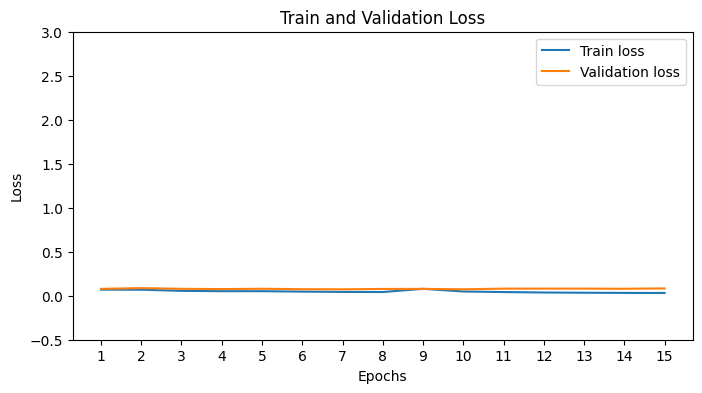

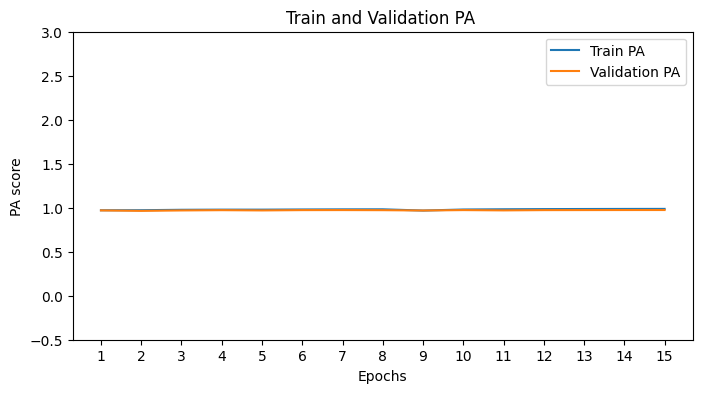

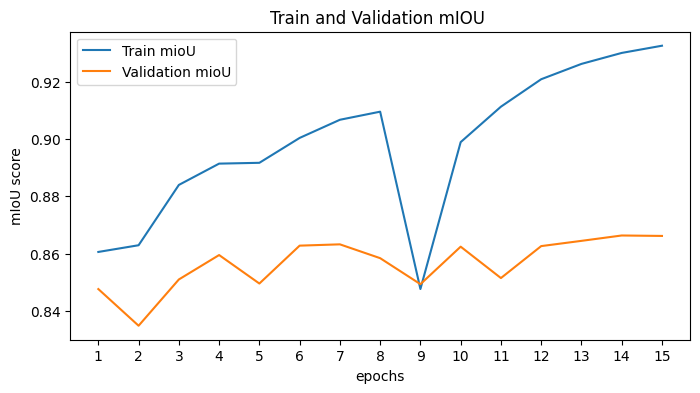

In [16]:
# r) Model jarayonidagi har bir epoch uchun train loss, validation loss, train pixel acc,
# validation pixel acc, train iou, validation iou evaluation metrics (learning curve) larini plt.plot yordamida chizib ko’rishga harakat qiling.
class plot():
    def __init__(self, r):

        
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_loss"], label = "Train loss")
        plt.plot(r["val_loss"], label = "Validation loss")
        plt.title("Train and Validation Loss")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.ylim(-0.5, 3)
        plt.legend()
        plt.show()


        plt.figure(figsize=(8,4))
        plt.plot(r["tr_pa"], label = "Train PA")
        plt.plot(r["val_pa"], label = "Validation PA")
        plt.title("Train and Validation PA ")
        plt.xticks(np.arange(len(r["val_pa"])), [i for i in range(1, len(r["val_pa"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("PA score")
        plt.legend()
        plt.ylim(-0.5, 3)
        plt.show()

        
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_iou"], label = "Train mioU")
        plt.plot(r["val_iou"], label = "Validation mioU")
        plt.title("Train and Validation mIOU ")
        plt.xticks(np.arange(len(r["val_iou"])), [i for i in range(1, len(r["val_iou"])+1)])
        plt.xlabel("epochs")
        plt.ylabel("mIoU score")
        plt.legend()
        plt.show()
plot(result_dict)

# 4 INFERENCE

In [ ]:
# q) Datasetni train, validation, va test setlariga ajratib, train, validation, va test dataloaderlarni yarating;
from torch.utils.data import random_split

train_data, valid_data, test_data  = random_split(dataset = arthropodia_ds, 
                                               lengths = [0.9, 0.05, 0.05], 
                                               generator = torch.Generator().manual_seed(13)) 

print(f"Train data size:{len(train_data)}   |  Valid data size:{len(valid_data)}    |    Test data size: {len(test_data)}")


test_dataloader = DataLoader(dataset = test_data, batch_size=1,  shuffle=False, num_workers=0)

print(f"Train dataloader size:{len(train_dataloader)}   |  Valid dataloader size:{len(val_dataloader)}    |    Test dataloader size: {len(test_dataloader)}\n")

print("One data point example size")
dataiter = iter(test_dataloader)

images, masks = next(dataiter)
print(images.shape)
print(masks.shape)
 

Train data size:4455   |  Valid data size:247    |    Test data size: 247
Train dataloader size:279   |  Valid dataloader size:16    |    Test dataloader size: 247

One data point example size
torch.Size([1, 3, 320, 320])
torch.Size([1, 320, 320])


INFERENCE NATIJASI:
Test Loss: 0.12  ||| Test PA score: 0.952813    ||| Test mIoU: 0.801393


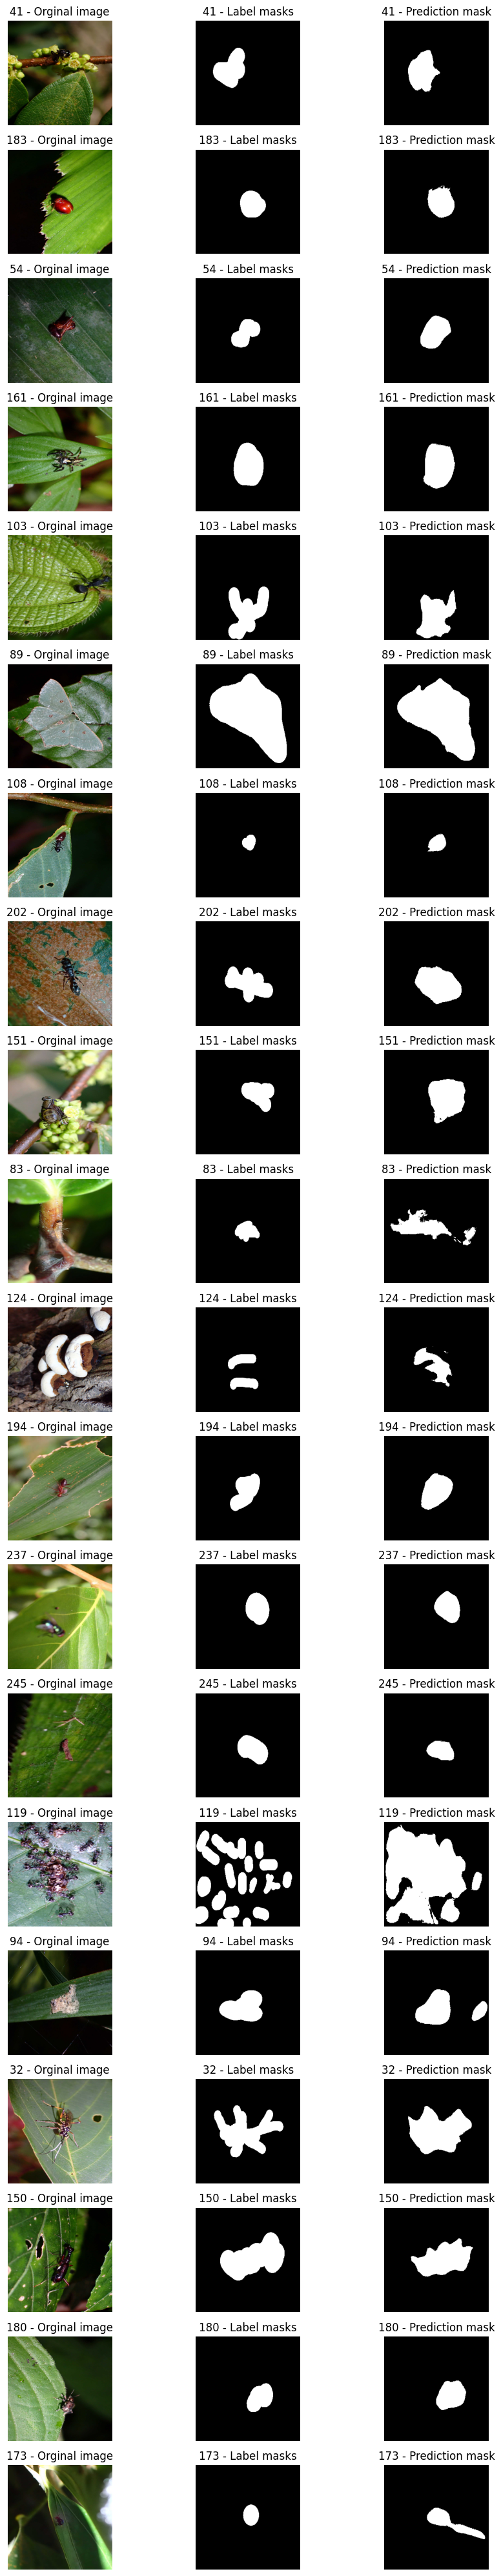

In [ ]:
#s) Train qilingan model yordamida inference jarayonini amalga oshiring va natijani plt.imshow yordamida ko’rsatib bering.
def inference(model, test_dl, device, n_imgs): 

        inference_data = []
        test_loss, test_pa, test_iou = 0, 0, 0
        for images, masks in test_dl:
            t_los, t_pa, t_iou = [],[],[] #loss, pa, and iou per image   
            for image, mask in zip(images, masks): 

                with torch.no_grad():
                    image, mask = image.to(device), mask.to(device)
                    prediction = model(torch.unsqueeze(image, dim=0))
                    pred_mask = torch.argmax(prediction, dim=1) 
                  
                #Convert tensors to Numpy arrays for plotting and store data to plot
                np_image = image.cpu().numpy().transpose(2,1,0)
                np_mask = mask.cpu().numpy()
                np_pred_mask = torch.squeeze(pred_mask, dim=0).cpu().numpy()
                inference_data.append((np_image, np_mask, np_pred_mask)) #add data to the list as tuple

                #get metrics in each batch per loop
                met = Metrics(pred=prediction, gt=torch.unsqueeze(mask,dim=0), loss_fn=loss_fn, n_cls=2)
                losses = met.loss()
                
                #batch ichidagi har bir rasm loss, pixel acc va iou larini hisoblaydi. 
                t_los.append(losses.item())
                t_pa.append(met.PA())
                t_iou.append(met.mIoU())
        
            test_loss += np.mean(t_los)
            test_pa += np.mean(t_pa)
            test_iou += np.mean(t_iou)

        #INFERENCE natijasi 
        test_loss /= len(test_dl)
        test_pa /= len(test_dl)
        test_iou /= len(test_dl)

        print(f"INFERENCE NATIJASI:")
        print(f"Test Loss: {test_loss:.2f}  ||| Test PA score: {test_pa:2f}    ||| Test mIoU: {test_iou:2f}")

    #Create figure and subplots 
        fig, axes = plt.subplots(n_imgs, 3, figsize=(10, n_imgs*2))  
        for i in range(n_imgs):
            random_idx = np.random.randint(0, len(test_dl))
            axes[i, 0].imshow(inference_data[random_idx][0]) #0 - org img,  2-pred mask
            axes[i, 1].imshow(inference_data[random_idx][1], cmap='gray') #1-mask
            axes[i, 2].imshow(inference_data[random_idx][2], cmap='gray') #3-pred mask
            axes[i, 0].set_title(f"{random_idx} - Orginal image")
            axes[i, 1].set_title(f"{random_idx} - Label mask")
            axes[i,2].set_title(f"{random_idx} - Prediction mask")
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')
            plt.tight_layout()

        plt.show()

best_model = torch.load(f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth")
inference(model=best_model, test_dl=test_dataloader, device=DEVICE, n_imgs=20)
